In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
from PIL import Image
from google.colab import drive
import os

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Define dataset directories
data_dir = '/content/drive/MyDrive/Project_ML/Pest/pestDataset'
output_dir = '/content/drive/MyDrive/Project_ML/Pest/Output'
pth_dir = os.path.join(output_dir, 'pth')
os.makedirs(pth_dir, exist_ok=True)

# Transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load only the training dataset (so class labels are assigned correctly)
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Get class indices for stratified splitting
targets = np.array(dataset.targets)  # Get class labels

# Split dataset into train (80%), val (10%), and test (10%) using indices
num_classes = len(dataset.classes)
train_indices, val_indices, test_indices = [], [], []

for c in range(num_classes):
    indices = np.where(targets == c)[0]  # Get all indices of class c
    np.random.shuffle(indices)  # Shuffle within class
    train_end = int(0.8 * len(indices))
    val_end = int(0.9 * len(indices))

    train_indices.extend(indices[:train_end])
    val_indices.extend(indices[train_end:val_end])
    test_indices.extend(indices[val_end:])

# Create dataset subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset info
print(f"Classes: {dataset.classes}")
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']
Train size: 4399, Val size: 550, Test size: 555


In [4]:
for _, labels in train_loader:
    print(labels.min().item(), labels.max().item())
    break


0 11


In [5]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [6]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=6):
        super(InceptionV3, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.MaxPool2d(3, stride=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 80, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(80, 192, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.maxpool2 = nn.MaxPool2d(3, stride=2)

        self.inception1 = InceptionModule(192, 64, 48, 64, 64, 96, 32)
        self.inception2 = InceptionModule(256, 64, 48, 64, 64, 96, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(288, num_classes)

    def forward(self,x):
      x= self.conv1(x)
      x=self.conv2(x)
      x=self.conv3(x)
      x=self.maxpool1(x)

      x=self.conv4(x)
      x=self.conv5(x)
      x=self.maxpool2(x)

      x=self.inception1(x)
      x=self.inception2(x)

      x=self.avgpool(x)
      x=torch.flatten(x,1)
      x=self.dropout(x)
      x=self.fc(x)
      return x

In [7]:
print(len(dataset.classes))


12


In [8]:
# Initialize model
model = InceptionV3(num_classes=12)

In [9]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [11]:
pth_dir = '/content/drive/MyDrive/Project_ML/Pest/Output/pth'
latest_checkpoint = os.path.join(pth_dir, 'inception_v3_70.pth') #insert new pth file

# Load model if checkpoint exists
if os.path.exists(latest_checkpoint):
    print(f"Loading model from {latest_checkpoint}")
    model.load_state_dict(torch.load(latest_checkpoint))
else:
    print("No checkpoint found. Starting training from scratch.")

Loading model from /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth


<ipython-input-11-a95a9fbef733>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_checkpoint))


In [12]:
#loss func and optimizer

criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(),lr=0.001)


In [13]:
from tqdm import tqdm

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch+1}/{num_epochs} training...")

    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if torch.isnan(loss):
            print("NaN loss detected. Skipping batch.")
            continue

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels).item()
        total_train += labels.size(0)

        progress_bar.set_postfix(loss=loss.item(), acc=100 * correct_train / total_train)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct_train / total_train
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    torch.save(model.state_dict(), f"{latest_checkpoint}_epoch3{epoch+1}.pth")
    print(f"Model saved at {latest_checkpoint}")

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/30 training...


Epoch 1: 100%|██████████| 138/138 [29:07<00:00, 12.66s/it, acc=74.4, loss=0.458]


Epoch 1 - Loss: 0.7625, Accuracy: 74.36%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7031, Accuracy: 77.09%
Epoch 2/30 training...


Epoch 2: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=77, loss=0.543]


Epoch 2 - Loss: 0.6678, Accuracy: 77.02%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.6571, Accuracy: 77.64%
Epoch 3/30 training...


Epoch 3: 100%|██████████| 138/138 [00:52<00:00,  2.63it/s, acc=78.1, loss=0.892]


Epoch 3 - Loss: 0.6512, Accuracy: 78.11%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7167, Accuracy: 76.00%
Epoch 4/30 training...


Epoch 4: 100%|██████████| 138/138 [00:52<00:00,  2.62it/s, acc=77.3, loss=0.598]


Epoch 4 - Loss: 0.6448, Accuracy: 77.34%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.6664, Accuracy: 78.18%
Epoch 5/30 training...


Epoch 5: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s, acc=79.2, loss=1.27]


Epoch 5 - Loss: 0.6187, Accuracy: 79.18%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.6115, Accuracy: 78.36%
Epoch 6/30 training...


Epoch 6: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=78.7, loss=0.534]


Epoch 6 - Loss: 0.6222, Accuracy: 78.70%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7259, Accuracy: 75.82%
Epoch 7/30 training...


Epoch 7: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=78.9, loss=0.529]


Epoch 7 - Loss: 0.6102, Accuracy: 78.95%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.6827, Accuracy: 76.73%
Epoch 8/30 training...


Epoch 8: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=81.6, loss=0.437]


Epoch 8 - Loss: 0.5339, Accuracy: 81.59%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7216, Accuracy: 74.55%
Epoch 9/30 training...


Epoch 9: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=80.6, loss=0.765]


Epoch 9 - Loss: 0.5740, Accuracy: 80.56%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.6974, Accuracy: 76.00%
Epoch 10/30 training...


Epoch 10: 100%|██████████| 138/138 [00:51<00:00,  2.65it/s, acc=82.3, loss=0.298]


Epoch 10 - Loss: 0.5343, Accuracy: 82.34%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7453, Accuracy: 74.55%
Epoch 11/30 training...


Epoch 11: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s, acc=82.3, loss=0.948]


Epoch 11 - Loss: 0.5162, Accuracy: 82.29%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7486, Accuracy: 76.55%
Epoch 12/30 training...


Epoch 12: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=81.8, loss=0.452]


Epoch 12 - Loss: 0.5276, Accuracy: 81.79%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7839, Accuracy: 74.91%
Epoch 13/30 training...


Epoch 13: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s, acc=83.6, loss=0.665]


Epoch 13 - Loss: 0.4642, Accuracy: 83.63%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7986, Accuracy: 75.09%
Epoch 14/30 training...


Epoch 14: 100%|██████████| 138/138 [00:52<00:00,  2.63it/s, acc=81.5, loss=0.676]


Epoch 14 - Loss: 0.5391, Accuracy: 81.54%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.8680, Accuracy: 72.00%
Epoch 15/30 training...


Epoch 15: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=84.2, loss=0.298]


Epoch 15 - Loss: 0.4658, Accuracy: 84.22%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.8623, Accuracy: 71.45%
Epoch 16/30 training...


Epoch 16: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=84.4, loss=0.693]


Epoch 16 - Loss: 0.4660, Accuracy: 84.41%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.8458, Accuracy: 72.91%
Epoch 17/30 training...


Epoch 17: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=84.8, loss=0.633]


Epoch 17 - Loss: 0.4271, Accuracy: 84.84%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7679, Accuracy: 74.36%
Epoch 18/30 training...


Epoch 18: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=84.5, loss=0.444]


Epoch 18 - Loss: 0.4576, Accuracy: 84.50%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9322, Accuracy: 67.64%
Epoch 19/30 training...


Epoch 19: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s, acc=85.2, loss=0.681]


Epoch 19 - Loss: 0.4274, Accuracy: 85.18%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9115, Accuracy: 71.09%
Epoch 20/30 training...


Epoch 20: 100%|██████████| 138/138 [00:52<00:00,  2.64it/s, acc=86, loss=0.548]


Epoch 20 - Loss: 0.4039, Accuracy: 85.95%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.7453, Accuracy: 75.64%
Epoch 21/30 training...


Epoch 21: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=85.8, loss=0.0727]


Epoch 21 - Loss: 0.3947, Accuracy: 85.84%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.8394, Accuracy: 72.91%
Epoch 22/30 training...


Epoch 22: 100%|██████████| 138/138 [00:51<00:00,  2.67it/s, acc=87.6, loss=0.963]


Epoch 22 - Loss: 0.3731, Accuracy: 87.63%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9499, Accuracy: 73.27%
Epoch 23/30 training...


Epoch 23: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=85.6, loss=0.359]


Epoch 23 - Loss: 0.4186, Accuracy: 85.56%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.8840, Accuracy: 72.00%
Epoch 24/30 training...


Epoch 24: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s, acc=86.3, loss=0.086]


Epoch 24 - Loss: 0.3900, Accuracy: 86.29%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9883, Accuracy: 69.82%
Epoch 25/30 training...


Epoch 25: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s, acc=87.1, loss=0.198]


Epoch 25 - Loss: 0.3902, Accuracy: 87.07%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9443, Accuracy: 72.36%
Epoch 26/30 training...


Epoch 26: 100%|██████████| 138/138 [00:51<00:00,  2.67it/s, acc=85.5, loss=0.718]


Epoch 26 - Loss: 0.4449, Accuracy: 85.52%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9510, Accuracy: 68.73%
Epoch 27/30 training...


Epoch 27: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=86.9, loss=0.23]


Epoch 27 - Loss: 0.3973, Accuracy: 86.88%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.8847, Accuracy: 73.27%
Epoch 28/30 training...


Epoch 28: 100%|██████████| 138/138 [00:51<00:00,  2.67it/s, acc=89, loss=0.144]


Epoch 28 - Loss: 0.3214, Accuracy: 89.04%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 1.0627, Accuracy: 69.82%
Epoch 29/30 training...


Epoch 29: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=87.3, loss=0.235]


Epoch 29 - Loss: 0.3570, Accuracy: 87.34%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 1.1131, Accuracy: 72.00%
Epoch 30/30 training...


Epoch 30: 100%|██████████| 138/138 [00:51<00:00,  2.66it/s, acc=87.2, loss=0.487]


Epoch 30 - Loss: 0.3786, Accuracy: 87.22%
Model saved at /content/drive/MyDrive/Project_ML/Pest/Output/pth/inception_v3_70.pth
Validation Loss: 0.9654, Accuracy: 72.00%


In [14]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


In [15]:
# Run testing
test_model(model, test_loader, device)

Test Accuracy: 72.61%


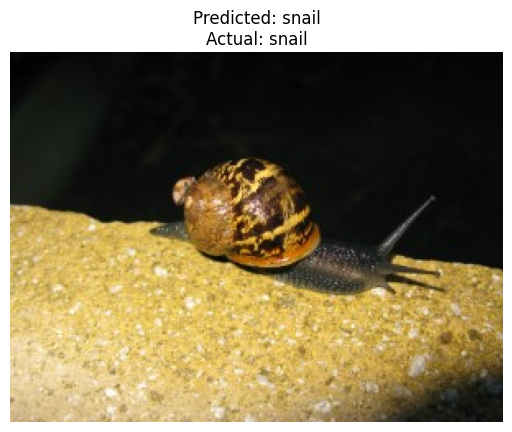

Predicted Class: snail


'snail'

In [16]:
import matplotlib.pyplot as plt
from PIL import Image


def classify_image(image_path, model, device, class_names, true_label=None):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    predicted_class = class_names[pred.item()]

    # Display the image with labels
    plt.imshow(image)
    title = f'Predicted: {predicted_class}'
    if true_label is not None:
        title += f'\nActual: {true_label}'

    plt.title(title)
    plt.axis("off")
    plt.show()

    print(f'Predicted Class: {predicted_class}')
    return predicted_class

# Example usage
image_path = '/content/drive/MyDrive/Project_ML/Pest/pestDataset/snail/snail (116).jpg'
true_label = 'snail'  # Set this if you know the actual class
classify_image(image_path, model, device, train_dataset.dataset.classes, true_label)
